In [1]:
import cv2
import numpy as np
import imutils
import glob
import matplotlib.pyplot as plt
import os

In [26]:
def CalibrateAndUndistort(calibDir, distortDirs):
    nbVertical = 6
    nbHorizontal = 9
    
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nbHorizontal*nbVertical,3), np.float32)
    objp[:,:2] = np.mgrid[0:nbVertical,0:nbHorizontal].T.reshape(-1,2) * 0.0336

    # Arrays to store object points and image points from all the images.
    objPoints = []
    leftImgPoints = []
    rightImgPoints = []
    
    # Read the images in this directory
    images = glob.glob(calibDir + '/right*.png')
    assert images

    #############################################################
    # Get corners of chessboard
    #############################################################
    # Finish process if no images are found
    if len(images) == 0:        
        print("ERROR: No images found in this input: {}.".format(imgsDirectory))
        return

    for fname in images:
        # First handle right image
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nbVertical, nbHorizontal), None)
        if ret == True:
            objPoints.append(objp)
            corners_subpix = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
            rightImgPoints.append(corners_subpix)
            img = cv2.drawChessboardCorners(img, (nbVertical, nbHorizontal), corners_subpix, ret)
            cv2.imshow('img',img)
            cv2.waitKey(100)

        # Then handle left image
        fname.replace('right', 'left')
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nbVertical, nbHorizontal), None)
        if ret == True:
            corners_subpix = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
            leftImgPoints.append(corners_subpix)
            img = cv2.drawChessboardCorners(img, (nbVertical, nbHorizontal), corners_subpix, ret)
            cv2.imshow('img',img)
            cv2.waitKey(100)
    cv2.destroyAllWindows()

    # Calibrate left camera
    l_ret, l_mtx, l_dist, l_rvecs, l_tvecs = cv2.calibrateCamera(objPoints, leftImgPoints, img.shape[0:2][::-1], None, None)

    # Calibrate right camera
    r_ret, r_mtx, r_dist, r_rvecs, r_tvecs = cv2.calibrateCamera(objPoints, rightImgPoints, img.shape[0:2][::-1], None, None)
    
    flags = cv2.CALIB_FIX_ASPECT_RATIO + cv2.CALIB_ZERO_TANGENT_DIST + cv2.CALIB_USE_INTRINSIC_GUESS +\
            cv2.CALIB_SAME_FOCAL_LENGTH + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_K3 + cv2.CALIB_FIX_K4 + cv2.CALIB_FIX_K5
    # Stereo calibration
    retval, mtx1, dist1, mtx2, dist2, R, T, E, F = cv2.stereoCalibrate(objPoints, leftImgPoints, rightImgPoints,\
                                        l_mtx, l_dist, r_mtx, r_dist, img.shape[0:2][::-1], flags=flags, criteria=criteria)
    
    # Rectification
    R1,R2,P1,P2,Q,_,_ = cv2.stereoRectify(mtx1, dist1, mtx2, dist2, img.shape[0:2][::-1], R, T, alpha=-1,\
                                            flags=cv2.CALIB_ZERO_DISPARITY)
    
    # Undistort
    for distortDir in distortDirs:
        undistortDir = distortDir.replace('distorted', 'undistorted')
        if not os.path.isdir(undistortDir):
            os.mkdir(undistortDir)
        if not os.path.isdir(undistortDir + '/left'):
            os.mkdir(undistortDir + '/left')
        if not os.path.isdir(undistortDir + '/right'):
            os.mkdir(undistortDir + '/right')
        leftDir = distortDir + '/left/*.png'
        images = glob.glob(leftDir)
        assert images
        for fname in images:
            leftName = fname
            left = cv2.imread(leftName)
            #left = cv2.cvtColor(left, cv2.COLOR_BGR2RGB)
            l_dst = cv2.undistort(left, mtx1, dist1, P1)
            cv2.imwrite(leftName.replace('distorted','undistorted'), l_dst)
            rightName = fname.replace('left', 'right').replace('Left', 'Right')
            right = cv2.imread(rightName)
            #right = cv2.cvtColor(right, cv2.COLOR_BGR2RGB)
            r_dst = cv2.undistort(right, mtx2, dist2, P2)
            cv2.imwrite(rightName.replace('distorted','undistorted'), r_dst)

In [28]:
def Depth_old(leftGrayImg, rightGrayImg, positionOnLeft):
    baseline = 120
    focalLength = 700#mtx1[0,0]
    stereo = cv2.StereoSGBM_create(minDisparity=24,
                               numDisparities=256,
                               blockSize=11,
                               P1=500,
                               P2=2000,
                               uniquenessRatio=5)

    #plt.figure(figsize=(10,10))
    disparity = stereo.compute(leftGrayImg,rightGrayImg).astype(np.float32) / 16.0
    #plt.imshow(disparity,'gray')
    depth = focalLength*baseline/disparity[positionOnLeft[0],positionOnLeft[1]]
    #print(f"Depth of pixel [{positionOnLeft[0]},{positionOnLeft[1]}] in mm: {depth}")
    return depth

In [27]:
CalibrateAndUndistort(calibDir='calibrationStereo', \
                      distortDirs=['distortedImagesWithOcclusion','distortedImagesWithoutOcclusion'])

193
435.23316062176167


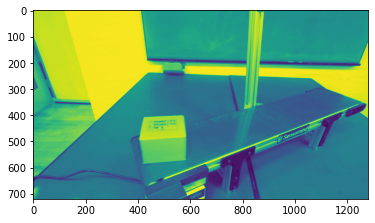

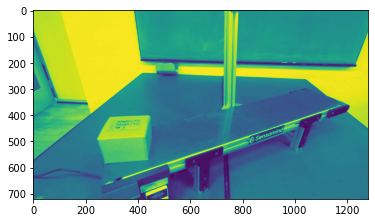

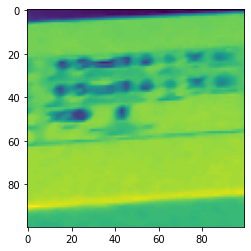

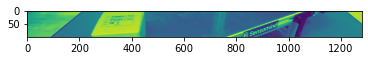

In [2]:
def sum_abs_diff(image1, image2):
    image1 = image1.astype('int32')
    image2 = image2.astype('int32')
    
    sad = 0
    
    if image1.shape == image2.shape:
        diff = image1 - image2
        sad = np.sum(np.absolute(diff))
    else:
        sad = -1
    
    return sad

def scan_line(span, template, search_col_min, search_col_max):
    min_place = -1
    min_value = float('inf')
    for i in range(search_col_min, search_col_max):
        diff = sum_abs_diff(span[:, i:i + span.shape[0]], template)
        if diff < min_value:
            min_value = diff
            min_place = i
    return (min_place, min_value)

def Depth(leftGrayImg, rightGrayImg, positionOnLeft, halfWindow):
    baseline = 120
    focalLength = 700
        
    template = leftGrayImg[positionOnLeft[0]-halfWindow:positionOnLeft[0]+halfWindow,\
                           positionOnLeft[1]-halfWindow:positionOnLeft[1]+halfWindow]
    plt.figure()
    plt.imshow(template)
    
    span = rightGrayImg[positionOnLeft[0]-halfWindow:positionOnLeft[0]+halfWindow, :]
    plt.figure()
    plt.imshow(span)
    min_place, min_value = scan_line(span, template, positionOnLeft[1]-250, positionOnLeft[1]-50-halfWindow)
    
    disparity = positionOnLeft[1]-min_place
    print(disparity)
    
    depth = focalLength*baseline/(disparity)
    #print(f"Depth of pixel [{positionOnLeft[0]},{positionOnLeft[1]}] in mm: {depth}")
    return depth

left = cv2.imread('undistortedImagesWithoutOcclusion/left/1585434288_069292068_Left.png')
left = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(left)
right = cv2.imread('undistortedImagesWithoutOcclusion/right/1585434288_069292068_Right.png')
right = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(right)

depth = Depth(left, right, positionOnLeft=(450,500), halfWindow=50)
print(depth)

# Tracking with depth

In [ ]:
import cv2
import numpy as np
import imutils
import glob
import matplotlib.pyplot as plt

def sum_abs_diff(image1, image2):
    image1 = image1.astype('int32')
    image2 = image2.astype('int32')
    
    sad = 0
    
    if image1.shape == image2.shape:
        diff = image1 - image2
        sad = np.sum(np.absolute(diff))
    else:
        sad = -1
    
    return sad

def scan_line(span, template, search_col_min, search_col_max):
    min_place = -1
    min_value = float('inf')
    for i in range(search_col_min, search_col_max):
        diff = sum_abs_diff(span[:, i:i + span.shape[0]], template)
        if diff < min_value:
            min_value = diff
            min_place = i
    return (min_place, min_value)

def Depth(leftGrayImg, rightGrayImg, positionOnLeft, halfWindow):
    baseline = 120
    focalLength = 700
    
    template = leftGrayImg[positionOnLeft[1]-halfWindow:positionOnLeft[1]+halfWindow,\
                           positionOnLeft[0]-halfWindow:positionOnLeft[0]+halfWindow]    
    span = rightGrayImg[positionOnLeft[1]-halfWindow:positionOnLeft[1]+halfWindow, :]
    min_place, min_value = scan_line(span, template, positionOnLeft[0]-250, positionOnLeft[0]-50-halfWindow)
    
    if min_place < 0:
        print('fail')
        
    disparity = positionOnLeft[0]-min_place
    #print(f"Disparity: {disparity} pixels")
    
    depth = focalLength*baseline/disparity
    #print(f"Depth of pixel [{positionOnLeft[0]},{positionOnLeft[1]}] in mm: {depth}")
    return depth

def BackgroundRemoval(leftImages):
    # Define kalman
    kalman = cv2.KalmanFilter(6,3)
    kalman.measurementMatrix = np.array([[1,0,0,0,0,0],
                                         [0,0,1,0,0,0],
                                         [0,0,0,0,1,0]], np.float32)
    kalman.transitionMatrix = np.array([[1,1,0,0,0,0],
                                        [0,1,0,0,0,0],
                                        [0,0,1,1,0,0],
                                        [0,0,0,1,0,0],
                                        [0,0,0,0,1,1],
                                        [0,0,0,0,0,1]], np.float32)
    kalman.processNoiseCov = np.eye(6, dtype=np.float32) * 0.03
    kalman.measurementNoiseCov = np.eye(3, dtype=np.float32) * 0.06
    measurement = np.array((3,1), np.float32)
    prediction = np.zeros((6,1), np.float32)
    
    # Background removal
    fgbg = cv2.createBackgroundSubtractorKNN(history=1000, dist2Threshold=1000, detectShadows=False)
    
    # Define parameters to check it is new object?
    thresholdCenter = 10
    prevCenter = (0, 0)
    prevRadius = 0
    thresholdRadius = 5
    
    for leftName in leftImages:
        rightName = leftName.replace('left','right').replace('Left','Right')
        
        # Read left frame to get object detection running
        originalFrame = cv2.imread(leftName)
        leftGray = cv2.cvtColor(originalFrame, cv2.COLOR_BGR2GRAY)
                
        # Make a prediction
        #prediction = kalman.predict()
        
        # Get the mask of the object
        mask = fgbg.apply(originalFrame)
        
        # Erode it and dilate it to avoid small points
        kernel = np.ones((5,5), np.uint8) 
        mask = cv2.erode(mask, kernel, iterations=1) 
        mask = cv2.dilate(mask, kernel, iterations=1) 

        # Bitwise-AND mask and original image
        frame = cv2.bitwise_and(originalFrame, originalFrame, mask=mask)
        
        # Make a crop to focus in the moving thing
        cropTop = 200
        cropBottom = 600
        cropLeft = 300
        cropRight = 1150
        cropped = mask[cropTop:cropBottom, cropLeft:cropRight]
        
        # Find contours
        cnts, _ = cv2.findContours(cropped.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        # Only proceed if at least one contour was found
        if len(cnts) > 0:
            # find the largest contour in the mask, then use
            # it to compute the minimum enclosing circle and
            # centroid
            c = max(cnts, key=cv2.contourArea)
            ((x, y), radius) = cv2.minEnclosingCircle(c)
            M = cv2.moments(c)
            if M["m00"] == 0.0:
                continue
            center = (int(M["m10"] / M["m00"])+cropLeft, int(M["m01"] / M["m00"])+cropTop)
            
            # only proceed if the radius meets a minimum size
            if radius > 20 and radius < 200 and radius + thresholdRadius >= prevRadius:
                # draw the circle and centroid on the frame,
                # then update the list of tracked points
                cv2.circle(originalFrame, (int(x)+cropLeft, int(y)+cropTop), int(radius),
                    (0, 255, 255), 2)
                cv2.circle(originalFrame, center, 5, (0, 0, 255), -1)
                
                right = cv2.imread(rightName)
                rightGray = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
                
                depth = Depth(leftGray, rightGray, center, 50)
                    
                cv2.putText(originalFrame, f"Depth: {depth:.2f} mm", (0,200), cv2.FONT_ITALIC, 1, (0,0,0))
                
                # Correct kalman 
                kalman.correct(np.array([np.float32(center[0]), np.float32(center[1]), np.float32(depth)], np.float32))
                
                prevRadius = radius
                text = "Object found at:"
                colour = (0, 255, 0)
                cv2.putText(originalFrame,"({}, {})".format(center[0], center[1]), (0, 100), cv2.FONT_ITALIC, 1, colour)

                if (center[0] > prevCenter[0] + thresholdCenter) and (center[1] < prevCenter[1] - thresholdCenter):
                    kalman = cv2.KalmanFilter(6,3)
                    kalman.measurementMatrix = np.array([[1,0,0,0,0,0],
                                         [0,0,1,0,0,0],
                                         [0,0,0,0,1,0]], np.float32)
                    kalman.transitionMatrix = np.array([[1,1,0,0,0,0],
                                        [0,1,0,0,0,0],
                                        [0,0,1,1,0,0],
                                        [0,0,0,1,0,0],
                                        [0,0,0,0,1,1],
                                        [0,0,0,0,0,1]], np.float32)
                    kalman.processNoiseCov = np.eye(6, dtype=np.float32) * 0.1#0.03
                    kalman.measurementNoiseCov = np.eye(3, dtype=np.float32) * 0.02
                    # New object
                    print("New object!")
                    objectFound = False
                    prevRadius = 0
                prevCenter = center
            else:
                # Object not found
                text = "Object not found"
                objectFound = False
                colour = (0, 0, 255)
                
        else: 
            # Object not found
            text = "Object not found"
            objectFound = False
            colour = (0, 0, 255)
            prevRadius = 0
            
        prediction = kalman.predict()
#         originalFrame = cv2.rectangle(originalFrame, (prediction[0]-(0.5*w), prediction[1]-(0.5*h)), 
#                                 (prediction[0]+(0.5*w), prediction[1]+(0.5*h)), (0,255,0),2)
        cv2.circle(originalFrame, (prediction[0]+prediction[2], prediction[1]+prediction[3]), 5, (255, 0, 0), -1)
        cv2.putText(originalFrame,"({}, {}, {})".format(prediction[0], prediction[2], prediction[4]), 
                    (0, 150), cv2.FONT_ITALIC, 1, colour)
    
            
        cv2.putText(originalFrame, text, (0, 50), cv2.FONT_ITALIC, 1, colour)

        cv2.imshow('res', originalFrame)

        #press 'q' to kill
        if cv2.waitKey(15) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()
    return 

leftImages = glob.glob('undistortedImagesWithoutOcclusion/left/*.png')
assert leftImages

BackgroundRemoval(leftImages)